In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

In [2]:
df = pd.read_csv('coffee_orders.csv',  encoding = "latin1")
df.head()

,Order ID,Customer ID,Location ID,Time of purchase,PreTax Total,Customer Order,Quantity
0,1897,3957,101,2024-11-06 00:50:29,16.70,Mocha Frappe Latte:5:3.34,5
1,7304,7905,104,2024-11-06 21:16:17,27.10,Matcha Latte:5:5.42,5
2,9623,3957,104,2024-11-03 09:34:35,4.66,Chai Latte:1:4.66,1
3,8113,7905,100,2024-11-04 07:31:56,4.12,Frappe Latte:1:4.12,1
4,6606,5124,101,2024-11-01 17:11:46,3.34,Mocha Frappe Latte:1:3.34,1


In [3]:
# Assuming 'Order Date' is the column with datetime information
df['Time of purchase'] = pd.to_datetime(df['Time of purchase'])  # Ensure it's in datetime format

# Create 'Hour' column (extract hour from the datetime)
df['Hour'] = df['Time of purchase'].dt.hour

# Create 'Day_of_week' column (extract day of the week as a number, Monday=0, Sunday=6)
df['Day_of_week'] = df['Time of purchase'].dt.dayofweek

# Now group by Customer ID and aggregate
aggregated_df = df.groupby('Customer ID').agg({
    'Order ID': 'count',  # Number of orders for the customer
    'PreTax Total': 'sum',  # Sum up the total spent
    'Quantity': 'sum',  # Total quantity of items
    'Hour': 'mean',  # Average time of purchase (hour of the day)
    'Day_of_week': lambda x: list(set(x)),  # Unique days the customer visited
    'Customer Order': lambda x: '; '.join(x)  # Combine all orders into a single string
}).reset_index()

# Rename columns for clarity
aggregated_df = aggregated_df.rename(columns={
    'Order ID': 'Total_Orders',
    'PreTax Total': 'Total_Spent',
    'Quantity': 'Total_Quantity',
    'Day_of_week': 'Unique_Visit_Days',
    'Customer Order': 'All_Orders'
})

# Display the resulting dataset
aggregated_df.head()


,Customer ID,Total_Orders,Total_Spent,Total_Quantity,Hour,Unique_Visit_Days,All_Orders
0,1005,4,30.16,7,14.75,"[0, 1, 6]",Mocha Frappe Latte:1:3.34; Hard Boiled Eggs:1:...
1,1016,1,7.88,2,14.00,[0],Tiramisu Latte:2:3.94
2,1043,2,7.81,2,5.50,"[2, 4]",Butter Crumb Cake:1:4.63; Caramel Frappe Latte...
3,1046,1,4.63,1,22.00,[0],Butter Crumb Cake:1:4.63
4,1059,1,2.84,1,2.00,[1],Cinnamon Bun:1:2.84


In [4]:
# Label dataset
# Find out how many items are ordered by a customer per visit
aggregated_df['Avg_Items_Per_Order'] = aggregated_df['Total_Quantity'] / aggregated_df['Total_Orders']

def label_customer(row):
    # Label based on visit frequency
    # a customer is a regular if they come in at least 3 times a week
    if len(row['Unique_Visit_Days']) >= 3:
        visit_label = 'Regular Customer'
    else:
        visit_label = 'Non-Regular Customer'
    
    # Label based on items per order
    # a customer is a high spender if they average at least 2 items per order
    if row['Avg_Items_Per_Order'] >= 2:
        spend_label = 'High Spend Customer'
    else:
        spend_label = 'Low Spend Customer'
    
    return f'{visit_label} - {spend_label}'

In [5]:
aggregated_df['Customer_Label'] = aggregated_df.apply(label_customer, axis=1)

# Display the resulting labels
aggregated_df[['Customer ID', 'Customer_Label']].head()
aggregated_df

,Customer ID,Total_Orders,Total_Spent,Total_Quantity,Hour,Unique_Visit_Days,All_Orders,Avg_Items_Per_Order,Customer_Label
0,1005,4,30.16,7,14.75,"[0, 1, 6]",Mocha Frappe Latte:1:3.34; Hard Boiled Eggs:1:...,1.75,Regular Customer - Low Spend Customer
1,1016,1,7.88,2,14.00,[0],Tiramisu Latte:2:3.94,2.00,Non-Regular Customer - High Spend Customer
2,1043,2,7.81,2,5.50,"[2, 4]",Butter Crumb Cake:1:4.63; Caramel Frappe Latte...,1.00,Non-Regular Customer - Low Spend Customer
3,1046,1,4.63,1,22.00,[0],Butter Crumb Cake:1:4.63,1.00,Non-Regular Customer - Low Spend Customer
4,1059,1,2.84,1,2.00,[1],Cinnamon Bun:1:2.84,1.00,Non-Regular Customer - Low Spend Customer
...,...,...,...,...,...,...,...,...,...
955,9944,2,25.45,7,5.50,[5],Hot Chocolate:4:2.89;Eggnog Latte:1:4.67;Corta...,3.50,Non-Regular Customer - High Spend Customer
956,9957,1,5.46,2,22.00,[2],Espresso:2:2.73,2.00,Non-Regular Customer - High Spend Customer
957,9974,2,21.04,5,11.50,"[0, 1]",Roasted Tomato Breakfast Roll:1:3.81;Vegan Bre...,2.50,Non-Regular Customer - High Spend Customer
958,9981,1,5.42,1,16.00,[3],Matcha Latte:1:5.42,1.00,Non-Regular Customer - Low Spend Customer


# Features Engineering


In [6]:
features = aggregated_df[['Total_Orders', 'Total_Spent', 'Total_Quantity', 'Avg_Items_Per_Order']]
labels = aggregated_df['Customer_Label']
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)
x_Train, x_Test, y_Train, y_Test = train_test_split(scaled_features, labels, test_size = 0.2 , random_state=42)


In [7]:
import pandas as pd
import numpy as np

# Example: Split combined labels and create binary features
# Assuming 'Customer_Label' is a column with combined labels
def split_labels(labels):
    return labels.split(' - ') if isinstance(labels, str) else []

# Apply the split function to create a list of labels for each customer
aggregated_df['Label_List'] = aggregated_df['Customer_Label'].apply(split_labels)

# Now we create binary features for each possible label
all_labels = set(label for label_list in aggregated_df['Label_List'] for label in label_list)
label_map = {label: i for i, label in enumerate(all_labels)}

# Create binary columns for each label
for label in all_labels:
    aggregated_df[label] = aggregated_df['Label_List'].apply(lambda x: 1 if label in x else 0)

# Check the resulting datafr
aggregated_df.head()

# Now you can proceed to use these labels in your clustering or KNN model


,Customer ID,Total_Orders,Total_Spent,Total_Quantity,Hour,Unique_Visit_Days,All_Orders,Avg_Items_Per_Order,Customer_Label,Label_List,Regular Customer,Low Spend Customer,High Spend Customer,Non-Regular Customer
0,1005,4,30.16,7,14.75,"[0, 1, 6]",Mocha Frappe Latte:1:3.34; Hard Boiled Eggs:1:...,1.75,Regular Customer - Low Spend Customer,"[Regular Customer, Low Spend Customer]",1,1,0,0
1,1016,1,7.88,2,14.00,[0],Tiramisu Latte:2:3.94,2.00,Non-Regular Customer - High Spend Customer,"[Non-Regular Customer, High Spend Customer]",0,0,1,1
2,1043,2,7.81,2,5.50,"[2, 4]",Butter Crumb Cake:1:4.63; Caramel Frappe Latte...,1.00,Non-Regular Customer - Low Spend Customer,"[Non-Regular Customer, Low Spend Customer]",0,1,0,1
3,1046,1,4.63,1,22.00,[0],Butter Crumb Cake:1:4.63,1.00,Non-Regular Customer - Low Spend Customer,"[Non-Regular Customer, Low Spend Customer]",0,1,0,1
4,1059,1,2.84,1,2.00,[1],Cinnamon Bun:1:2.84,1.00,Non-Regular Customer - Low Spend Customer,"[Non-Regular Customer, Low Spend Customer]",0,1,0,1


In [14]:
# Initialize knn model
import joblib
knn = KNeighborsClassifier(n_neighbors=4)
knn.fit(x_Train, y_Train)

y_pred = knn.predict(x_Test)

# Evaluate the model using accuracy
accuracy = accuracy_score(y_Test, y_pred)
print(f"Accuracy of KNN model: {accuracy * 100:.2f}%")
joblib.dump(knn, 'knn_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
feature_order = aggregated_df.columns.tolist()
with open('feature_order.txt', 'w') as f:
    for feature in feature_order:
        f.write(f"{feature}\n")


Accuracy of KNN model: 96.35%


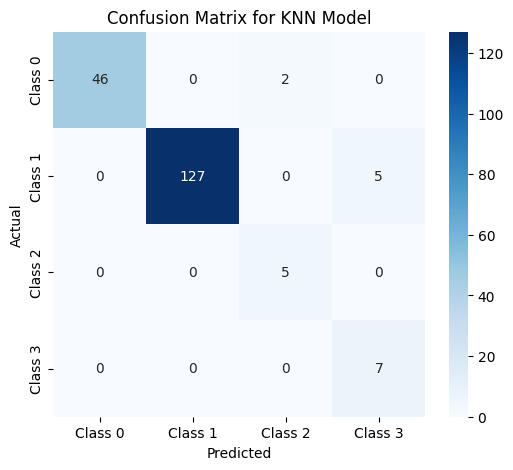

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_Test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'], yticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'])
plt.title('Confusion Matrix for KNN Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [62]:
import pandas as pd
import joblib
from sklearn.preprocessing import StandardScaler

# Load the trained KNN model and the scaler
knn = joblib.load('knn_model.pkl')  # Load the trained KNN model
scaler = joblib.load('scaler.pkl')  # Load the StandardScaler that was used during training

# Define new customer data (example)
new_customer_data = pd.DataFrame([{
    'Total_Orders': 3,
    'Total_Spent': 5.00,
    'Total_Quantity': 2,
    'Avg_Items_Per_Order': 3/2  # 5 items ordered in 3 orders
}])

# Define the feature order (same order as was used during training)
feature_order = ['Total_Orders', 'Total_Spent', 'Total_Quantity', 'Avg_Items_Per_Order']
new_customer_data = new_customer_data[feature_order]

# Ensure the data is scaled using the same scaler
new_customer_data_scaled = scaler.transform(new_customer_data)

# Predict the label for the new customer using the trained KNN model
prediction = knn.predict(new_customer_data_scaled)

# Print the predicted label
print(f"Predicted Label for the New Customer: {prediction[0]}")


Predicted Label for the New Customer: Regular Customer - Low Spend Customer
